In [36]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans

In [2]:
data = pd.read_csv('data/autos.csv', encoding='cp1252')

In [3]:
train, test = train_test_split(data, test_size=0.7, random_state=666)

In [4]:
profile = ProfileReport(train, title="Pandas Profiling Report")

profile

# Preliminar columns selection

In [5]:
train = train.loc[:,[
    'price','abtest','vehicleType','yearOfRegistration','gearbox','powerPS','model','kilometer',
    'monthOfRegistration','fuelType','brand','notRepairedDamage','postalCode','dateCrawled'
]]

Notes:
* price has zero values and very large values. --> filter price > 0 and < 80000000
* vehicleType has 10% NA. --> create a "NA" class
* yearOfRegistration has zero values. --> filter year between 1863 and 2017
* gearbox has 5.4% NA. --> replace by most frequent gearbox for that brand-model combination
* powerPS has zero values. --> replace by mean powerPS for that brand-model combination
* model has 5.6% NA. --> create a "NA" class
* monthOfRegistration has 10% zero values. (not used)
* fuelType has 8.9% NA. --> create a "NA" class
* notRepairedDamage has 19.3% NA. --> put as not repaird. If user doesn't mentions it, it is assumed there was no damage.
* dateCrawled has high uniformity. (not used)

# Data exploration

In [6]:
train.dtypes

price                   int64
abtest                 object
vehicleType            object
yearOfRegistration      int64
gearbox                object
powerPS                 int64
model                  object
kilometer               int64
monthOfRegistration     int64
fuelType               object
brand                  object
notRepairedDamage      object
postalCode              int64
dateCrawled            object
dtype: object

## Price

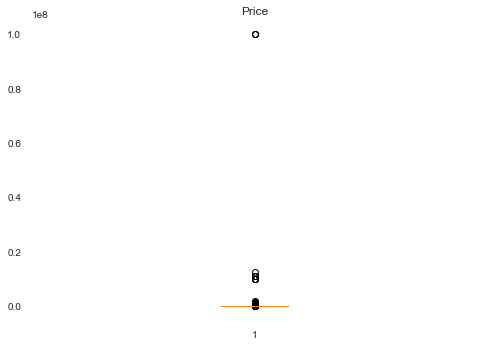

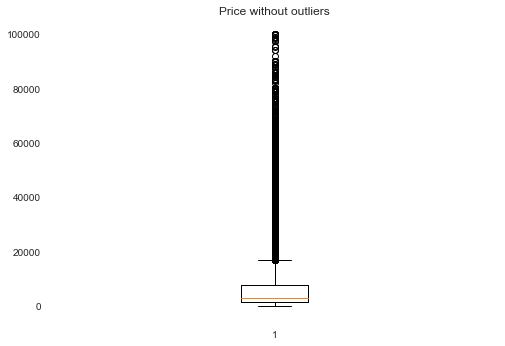

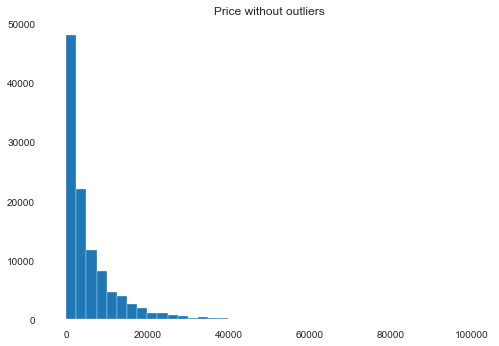

In [7]:
plt.boxplot(train.price)
plt.title('Price')
plt.show()

price = train.price.copy()
price = price[(price > 0) & (price < 100000)]
plt.boxplot(price)
plt.title('Price without outliers')
plt.show()

plt.hist(price, bins=40)
plt.title('Price without outliers')
plt.show()

### REMOVE outlier price

In [8]:
train = train.loc[train.price < 80000000,]

### Price variable discretization

In [9]:
price = train.price.copy().values
price = np.expand_dims(price, axis=1)

price_discretizer = KBinsDiscretizer(n_bins=12, encode='ordinal', strategy='quantile')
price_discretizer.fit(price)

price = price_discretizer.transform(price)

## Abtest

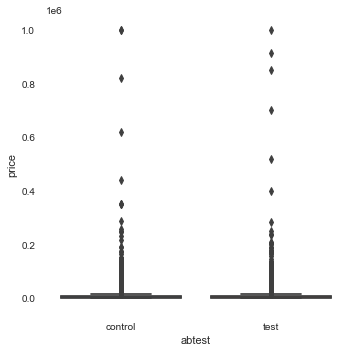

In [10]:
aux = train.copy().loc[train.price < 1000000]
sns.catplot(x="abtest", y="price", kind="box", data=aux)
plt.show()

There is no difference in price.

## vehicleType

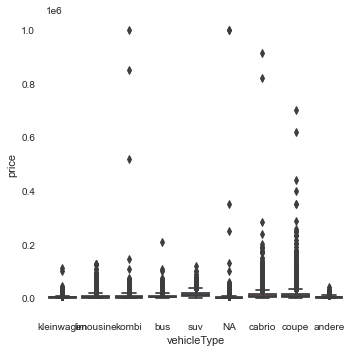

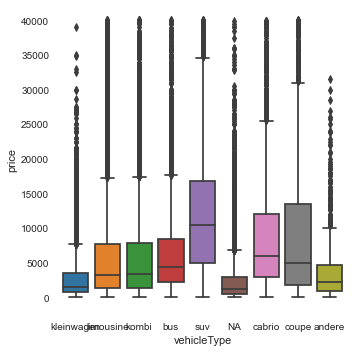

In [105]:
aux = train.copy().loc[train.price < 1000000]
aux.loc[aux.vehicleType.isna(),'vehicleType'] = "NA"
sns.catplot(x="vehicleType", y="price", kind="box", data=aux)
plt.show()
aux = train.copy().loc[train.price < 40000]
aux.loc[aux.vehicleType.isna(),'vehicleType'] = "NA"
sns.catplot(x="vehicleType", y="price", kind="box", data=aux)
plt.show()

## yearOfRegistration

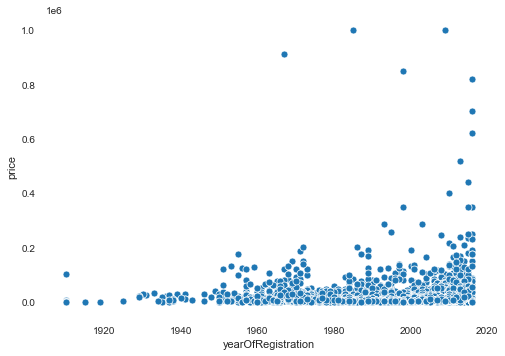

In [18]:
aux = train.copy().loc[train.price < 1000000]
aux = aux.loc[(aux.yearOfRegistration > 1863) & (aux.yearOfRegistration < 2017)]
sns.scatterplot(x="yearOfRegistration", y="price", data=aux)
plt.show()

## gearbox

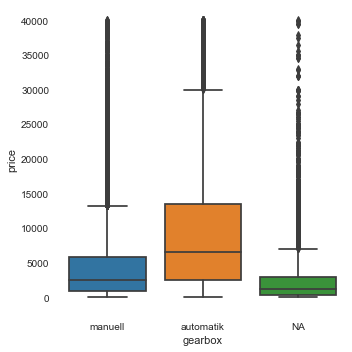

In [106]:
aux = train.copy().loc[train.price < 40000]
aux.loc[aux.gearbox.isna(),'gearbox'] = "NA"
sns.catplot(x="gearbox", y="price", kind="box", data=aux)
plt.show()

## powerPS

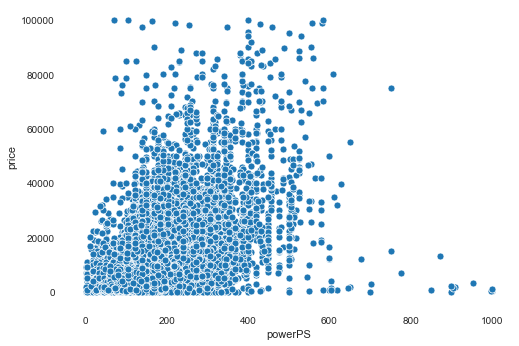

In [29]:
aux = train.copy().loc[train.price < 100000]
aux = aux.copy().loc[(aux.powerPS > 0) & (aux.powerPS < 1000)]
sns.scatterplot(x="powerPS", y="price", data=aux)
plt.show()

## model

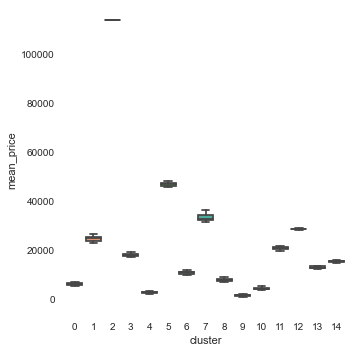

In [109]:
aux = train.copy().loc[:,['model','price']]
aux.loc[aux.model.isna(),'model'] = 'NA'
aux = aux.groupby(['model']).mean()

model_clustering = KMeans(n_clusters=15, random_state=666)
model_clustering.fit(np.expand_dims(aux.price.values, axis=1))
models_clustered = model_clustering.predict(np.expand_dims(aux.price.values, axis=1))

model_clusters = pd.DataFrame({'model': aux.index.values, 'cluster': models_clustered, 'mean_price': aux.loc[:,'price']}).reset_index(drop=True)


sns.catplot(x='cluster', y='mean_price', kind="box", data=model_clusters)
plt.show()

## brand

This variable is useful for the cases where model is NA.

In [114]:
len(train.brand.unique())

40

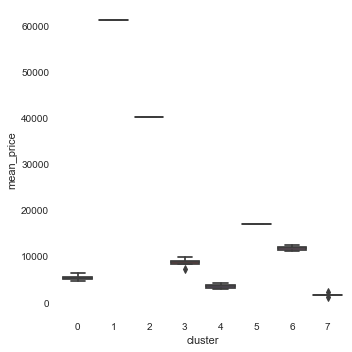

In [113]:
aux = train.copy().loc[:,['brand','price']]
aux = aux.groupby(['brand']).mean()

brand_clustering = KMeans(n_clusters=8, random_state=666)
brand_clustering.fit(np.expand_dims(aux.price.values, axis=1))
brands_clustered = brand_clustering.predict(np.expand_dims(aux.price.values, axis=1))

brand_clusters = pd.DataFrame({'brand': aux.index.values, 'cluster': brands_clustered, 'mean_price': aux.loc[:,'price']}).reset_index(drop=True)


sns.catplot(x='cluster', y='mean_price', kind="box", data=brand_clusters)
plt.show()

## kilometer

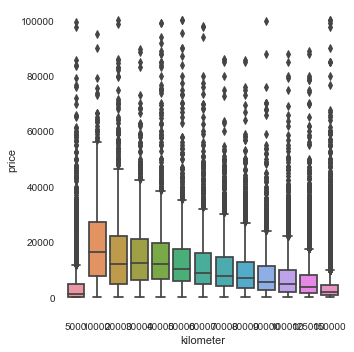

In [90]:
aux = train.copy().loc[train.price < 100000]
sns.catplot(x="kilometer", y="price", kind='box', data=aux)
plt.show()

## monthOfRegistration

Non informative and thas 10% NAs.

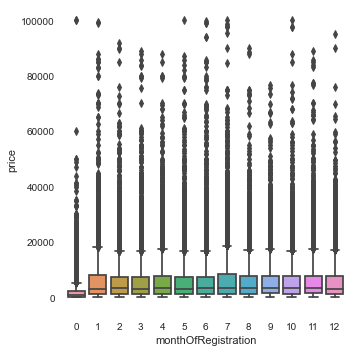

In [91]:
aux = train.copy().loc[train.price < 100000]
sns.catplot(x="monthOfRegistration", y="price", kind='box', data=aux)
plt.show()

## fuelType

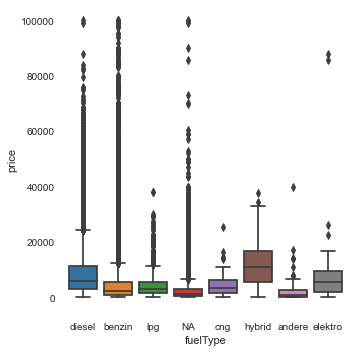

In [116]:
aux = train.copy().loc[train.price < 100000]
aux.loc[aux.fuelType.isna(),'fuelType'] = 'NA'
sns.catplot(x="fuelType", y="price", kind='box', data=aux)
plt.show()

## notRepairedDamage

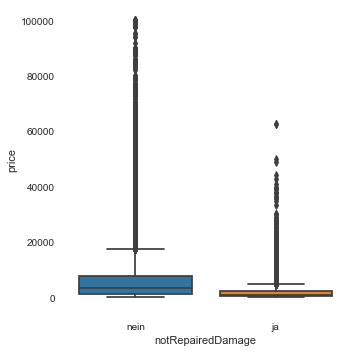

In [117]:
aux = train.copy().loc[train.price < 100000]
aux.loc[aux.notRepairedDamage.isna(), 'notRepairedDamage'] = 'nein'
sns.catplot(x="notRepairedDamage", y="price", kind='box', data=aux)
plt.show()

## postalCode

In [94]:
len(train.postalCode.unique())

7770

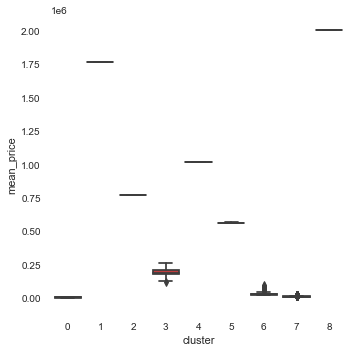

In [101]:
aux = train.copy().loc[:,['postalCode','price']]
aux = aux.groupby(['postalCode']).mean()

postalcode_clustering = KMeans(n_clusters=9, random_state=666)
postalcode_clustering.fit(np.expand_dims(aux.price.values, axis=1))
postalcode_clustered = postalcode_clustering.predict(np.expand_dims(aux.price.values, axis=1))

postalcode_clusters = pd.DataFrame({'postalCode': aux.index.values, 'cluster': postalcode_clustered, 'mean_price': aux.loc[:,'price']}).reset_index(drop=True)


sns.catplot(x='cluster', y='mean_price', kind="box", data=postalcode_clusters)
plt.show()